# SpectralNET Exploring Spatial Spectral Wavelet CNN for Hyper Spectral Image Classification

**Authors:** Tanmay CHAKRABORTY and Utkarsh TREHAN

In [1]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from tensorflow.keras.models import Model
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from tensorflow.keras import backend as Kb
from keras.layers import Lambda
from keras.layers import Activation
from keras.layers import add, concatenate
from keras.layers import AveragePooling2D
from keras.utils import plot_model
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
 
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from operator import truediv
 
from plotly.offline import init_notebook_mode
 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
!pip install spectral
import spectral

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import AveragePooling3D

2024-07-15 11:19:47.610537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 11:19:47.638127: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 11:19:47.638170: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-15 11:19:47.656978: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 11:19:48.618152: W tensorflow/com


[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
def applyFA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    fa = FactorAnalysis(n_components=numComponents, random_state=0)
    newX = fa.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, fa
    

In [3]:
# def applyPCA(X, numComponents=75):
#     newX = np.reshape(X, (-1, X.shape[2]))
#     pca = PCA(n_components=numComponents, whiten=True)
#     newX = pca.fit_transform(newX)
#     newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
#     return newX, pca

In [4]:
## GLOBAL VARIABLES
dataset = 'HSN'
test_ratio = 0.95
windowSize = 12

In [5]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'HSN':
        data = sio.loadmat(os.path.join(data_path, '2013_IEEE_GRSS_DF_Contest_CASI_349_1905_144.mat'))['ans']
        labels = sio.loadmat(os.path.join(data_path, 'GRSS2013.mat'))['name']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [6]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [7]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [8]:
def createImageCubes(X, y, windowSize=8, removeZeroLabels = True):
    margin = int((windowSize) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin , c - margin:c + margin ]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [9]:
X, y = loadData(dataset)

X.shape, y.shape

((349, 1905, 144), (349, 1905))

In [10]:
K = X.shape[2]

In [11]:
K = 3 if dataset == 'IP' else 3
X,fa = applyFA(X,numComponents=K)

X.shape

(349, 1905, 3)

In [12]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((15029, 12, 12, 3), (15029,))

In [13]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((751, 12, 12, 3), (14278, 12, 12, 3), (751,), (14278,))

In [14]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(751, 12, 12, 3, 1)

In [15]:
ytrain = to_categorical(ytrain)
ytrain.shape

(751, 15)

In [16]:
S1 = windowSize
L1 = K
if (dataset == 'PU'):
    output_units = 9
elif (dataset == 'HSN'):
    output_units = 15
else:
    output_units = 16

In [17]:
def WaveletTransformAxisY(batch_img):
    odd_img = batch_img[:, ::2]
    even_img = batch_img[:, 1::2]
    L = (odd_img + even_img) * 0.5
    H = Kb.abs(odd_img - even_img) * 0.5  # Normalize high-pass coefficients
    return L, H

def WaveletTransformAxisX(batch_img):
    # Perform the operation directly on the transposed image
    tmp_batch = Kb.permute_dimensions(batch_img, [0, 2, 1])
    odd_img = tmp_batch[:, ::2]
    even_img = tmp_batch[:, 1::2]
    _dst_L = (odd_img + even_img) * 0.5
    _dst_H = Kb.abs(odd_img - even_img) * 0.5  # Normalize high-pass coefficients
    dst_L = Kb.permute_dimensions(_dst_L, [0, 2, 1])
    dst_H = Kb.permute_dimensions(_dst_H, [0, 2, 1])
    return dst_L, dst_H

In [18]:
def Wavelet(batch_image):
    # make channel first image
    batch_image = Kb.permute_dimensions(batch_image, [0, 3, 1, 2])
    r = batch_image[:, 0]
    g = batch_image[:, 1]
    b = batch_image[:, 2]

    # level 1 decomposition
    wavelet_L, wavelet_H = WaveletTransformAxisY(r)
    r_wavelet_LL, r_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    r_wavelet_HL, r_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(g)
    g_wavelet_LL, g_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    g_wavelet_HL, g_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(b)
    b_wavelet_LL, b_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    b_wavelet_HL, b_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_data = [r_wavelet_LL, r_wavelet_LH, r_wavelet_HL, r_wavelet_HH, 
                    g_wavelet_LL, g_wavelet_LH, g_wavelet_HL, g_wavelet_HH,
                    b_wavelet_LL, b_wavelet_LH, b_wavelet_HL, b_wavelet_HH]
    transform_batch = Kb.stack(wavelet_data, axis=1)

    # level 2 decomposition
    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(r_wavelet_LL)
    r_wavelet_LL2, r_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    r_wavelet_HL2, r_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(g_wavelet_LL)
    g_wavelet_LL2, g_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    g_wavelet_HL2, g_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(b_wavelet_LL)
    b_wavelet_LL2, b_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    b_wavelet_HL2, b_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_data_l2 = [r_wavelet_LL2, r_wavelet_LH2, r_wavelet_HL2, r_wavelet_HH2, 
                    g_wavelet_LL2, g_wavelet_LH2, g_wavelet_HL2, g_wavelet_HH2,
                    b_wavelet_LL2, b_wavelet_LH2, b_wavelet_HL2, b_wavelet_HH2]
    transform_batch_l2 = Kb.stack(wavelet_data_l2, axis=1)

    # level 3 decomposition
    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(r_wavelet_LL2)
    r_wavelet_LL3, r_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    r_wavelet_HL3, r_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(g_wavelet_LL2)
    g_wavelet_LL3, g_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    g_wavelet_HL3, g_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL2)
    b_wavelet_LL3, b_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    b_wavelet_HL3, b_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_data_l3 = [r_wavelet_LL3, r_wavelet_LH3, r_wavelet_HL3, r_wavelet_HH3, 
                    g_wavelet_LL3, g_wavelet_LH3, g_wavelet_HL3, g_wavelet_HH3,
                    b_wavelet_LL3, b_wavelet_LH3, b_wavelet_HL3, b_wavelet_HH3]
    transform_batch_l3 = Kb.stack(wavelet_data_l3, axis=1)

    # level 4 decomposition
    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(r_wavelet_LL3)
    r_wavelet_LL4, r_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    r_wavelet_HL4, r_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(g_wavelet_LL3)
    g_wavelet_LL4, g_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    g_wavelet_HL4, g_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(b_wavelet_LL3)
    b_wavelet_LL4, b_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    b_wavelet_HL4, b_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_data_l4 = [r_wavelet_LL4, r_wavelet_LH4, r_wavelet_HL4, r_wavelet_HH4, 
                    g_wavelet_LL4, g_wavelet_LH4, g_wavelet_HL4, g_wavelet_HH4,
                    b_wavelet_LL4, b_wavelet_LH4, b_wavelet_HL4, b_wavelet_HH4]
    transform_batch_l4 = Kb.stack(wavelet_data_l4, axis=1)

    decom_level_1 = Kb.expand_dims(Kb.permute_dimensions(transform_batch, [0, 2, 3, 1]), axis=-1)
    decom_level_2 = Kb.expand_dims(Kb.permute_dimensions(transform_batch_l2, [0, 2, 3, 1]), axis=-1)
    decom_level_3 = Kb.expand_dims(Kb.permute_dimensions(transform_batch_l3, [0, 2, 3, 1]), axis=-1)
    decom_level_4 = Kb.expand_dims(Kb.permute_dimensions(transform_batch_l4, [0, 2, 3, 1]), axis=-1)

    
    return [decom_level_1, decom_level_2, decom_level_3, decom_level_4]


def Wavelet_out_shape(input_shapes):
    # print('in to shape')
    return [tuple([None, 6, 6, 12, 1]), tuple([None, 3, 3, 12, 1]), 
            tuple([None, 2, 2, 12, 1]), tuple([None, 1, 1, 12, 1])]

In [19]:
img_batch = Kb.zeros(shape=(8, 12, 12, 3), dtype='float32')
Wavelet(img_batch)

2024-07-15 11:21:59.821221: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7035 MB memory:  -> device: 0, name: Quadro P4000, pci bus id: 0000:73:00.0, compute capability: 6.1


[<tf.Tensor: shape=(8, 6, 6, 12, 1), dtype=float32, numpy=
 array([[[[[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]],
 
          [[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]],
 
          [[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]],
 
          [[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]],
 
          [[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]],
 
          [[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]]],
 
 
         [[[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]],
 
          [[0.],
           [0.],
           [0.],
           ...,
           [0.],
       

In [20]:
from tensorflow.keras.layers import Input, Concatenate, Conv2D, Flatten, Dense, Reshape

In [21]:
def get_wavelet_cnn_model():
 
    input_shape =  12, 12, 3
 
    input_ = Input(input_shape, name='the_input')
    # wavelet = Lambda(Wavelet, name='wavelet')
    wavelet = Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
    input1, input2, input3, input4 = wavelet(input_)

    # Define convolutional layers to process each input to the same shape
    conv1 = Conv2D(32, (1, 1), activation='relu')(input1)
    conv2 = Conv2D(32, (1, 1), activation='relu')(input2)
    conv3 = Conv2D(32, (1, 1), activation='relu')(input3)
    conv4 = Conv2D(32, (1, 1), activation='relu')(input4)

    # Flatten the conv layers
    flat1 = Flatten()(conv1)
    flat2 = Flatten()(conv2)
    flat3 = Flatten()(conv3)
    flat4 = Flatten()(conv4)

    # Concatenate the layers
    concatenated = Concatenate(axis=-1)([flat1, flat2, flat3, flat4])

    # Pass through additional dense layers
    x = Dense(128, activation='relu')(concatenated)
    flatten_layer = Dense(64, activation='relu')(x)
    
    num_classes = output_units
    output_layer = Dense(num_classes, activation='softmax')(flatten_layer)
    
    model = Model(inputs=input_, outputs=output_layer)
    model.summary()
    return model

In [22]:
model = get_wavelet_cnn_model()

ValueError: Kernel shape must have the same length as input, but received kernel of shape (1, 1, 1, 32) and input of shape (None, 6, 6, 12, 1).

In [ ]:
#adam = Adam(lr=0.001, decay=1e-06)
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
filepath = "best-model_PU_3DCNN_HSI.keras"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

In [ ]:
import time  

In [ ]:
start_time = time.time()

history = model.fit(x=Xtrain, y=ytrain, batch_size = 32, epochs=50, callbacks=callbacks_list)

end_time = time.time()  
total_time = end_time - start_time  
print(f'Finished training. Total training time: {total_time:.2f} seconds')  # Print the total training time

# Validation

In [ ]:
plt.figure(figsize=(7,7)) 
plt.grid() 
plt.plot(history.history['loss'])   
#plt.plot(history.history['val_loss'])
#plt.ylabel('Loss') 
#plt.xlabel('Epochs') 
#plt.legend(['Training','Validation'], loc='upper right') 
#plt.savefig("loss_curve.pdf") 
#plt.show()
#plt.figure(figsize=(5,5)) 
#plt.ylim(0,1.1) 
#plt.grid() 
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
#plt.ylabel('Accuracy') 
#plt.xlabel('Epochs') 
#plt.legend(['Training','Validation']) 
#plt.savefig("acc_curve.pdf") 
#plt.show()

In [ ]:
# load best weights
model.load_weights("best-model_PU_3DCNN_HSI.keras")
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

In [ ]:
ytest = to_categorical(ytest)
ytest.shape

In [ ]:
start_time = time.time()

Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

end_time = time.time()  # End timing
test_time = end_time - start_time  # Calculate the test time
print(f'Test time: {test_time:.2f} seconds')

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

In [ ]:
# Overall Accuracy
oa = accuracy_score(np.argmax(ytest, axis=1), y_pred_test)

# Confusion Matrix
cm = confusion_matrix(np.argmax(ytest, axis=1), y_pred_test)
# Calculate per-class accuracy from the confusion matrix
class_accuracy = cm.diagonal() / cm.sum(axis=1)
# Average Accuracy
aa = np.mean(class_accuracy)

# Kappa Coefficient
kappa = cohen_kappa_score(np.argmax(ytest, axis=1), y_pred_test)

print(f'Overall Accuracy (OA): {oa:.4f}')
print(f'Average Accuracy (AA): {aa:.4f}')
print(f'Kappa Coefficient: {kappa:.4f}')
for i, acc in enumerate(class_accuracy): print(f'Class {i+1} Accuracy: {acc:.4f}')

In [34]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [49]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [50]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)

1523/1523 ━━━━━━━━━━━━━━━━━━━━ 55s 36ms/step
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 62s 37ms/step - accuracy: 0.9999 - loss: 4.3089e-04


In [51]:
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

In [52]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [53]:
# load the original image
X, y = loadData(dataset)

In [54]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize

In [55]:
K = 3
X,fa = applyFA(X, numComponents=K)


In [56]:
X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


C:\Users\ranja\AppData\Local\Temp\ipykernel_21560\1944015956.py:13: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━

C:\Users\Utkarsh Trehan\anaconda3\envs\MALIS\lib\site-packages\spectral\graphics\spypylab.py:27: MatplotlibDeprecationWarning:


The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.

C:\Users\Utkarsh Trehan\anaconda3\envs\MALIS\lib\site-packages\spectral\graphics\spypylab.py:905: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.



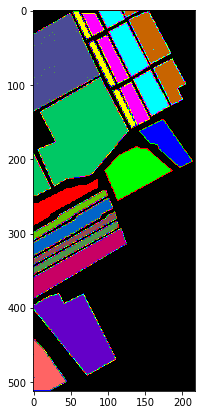

In [43]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

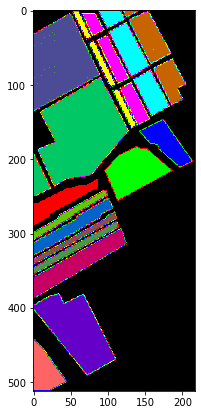

In [44]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [45]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)